# Extract Data from Graph

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calc_contours(image_path):
  img = cv2.imread(image_path)

  # Apply bilateral filter
  img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)

  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Apply thresholding to remove text and noise
  _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

  # Apply ROI masking to exclude non-graph regions
  mask = np.zeros_like(thresh)
  mask[50:400, 100:700] = 255
  masked_thresh = cv2.bitwise_and(thresh, mask)

  # Apply edge detection using the Canny algorithm
  edges = cv2.Canny(gray, 100, 200)

  # Apply horizontal line detection using HoughLinesP
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=250, maxLineGap=15)
  horizontal_lines = []
  for line in lines:
      x1, y1, x2, y2 = line[0]
      if abs(y1 - y2) < 5: # Check if the line is horizontal
          horizontal_lines.append(line)

  # Draw the detected lines on the image
  for line in horizontal_lines:
      x1, y1, x2, y2 = line[0]
      # cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)

  # Find contours in the image
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Filter out unwanted contours based on contour area and aspect ratio
  bars = []
  for cnt in contours:
      area = cv2.contourArea(cnt)
      x, y, w, h = cv2.boundingRect(cnt)
      aspect_ratio = float(w) / h
      if area > 7 and aspect_ratio > 5 and aspect_ratio < 50000:
          bars.append(cnt)

  ###### 2 consecutive element from the bars represent single contour only
  ###### and we will consider only one of them, so we will filter out odd index elemnts from the "bars"

  def filter_bars(bars):
    lst = []
    for i in range(len(bars)):
      if(i%2==1):
        lst.append(bars[i])
    return lst

  bars = filter_bars(bars)

  # Draw the remaining contours on the image
  cv2.drawContours(img, bars, -1, (255, 255, 0), 2)

  # Show the image
  plt.imshow(img)
  return bars


In [3]:
from PIL import ImageDraw, ImageFont
from transformers import BertTokenizer,AdamW, LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2ForTokenClassification
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler 
import torch 
from tqdm import tqdm, trange

def loadFromLayoutlmv2():
  feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")# apply_ocr is set to True by default
  tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased") 
  model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
  return feature_extractor,tokenizer,model

def labelForBoxes():
  dataset = load_dataset("nielsr/funsd", split="test")
  # define id2label, label2color
  labels = dataset.features['ner_tags'].feature.names
  id2label = {v: k for v, k in enumerate(labels)}
  label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
  return id2label, label2color

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

def process_image(image,id2label,label2color,feature_extractor,tokenizer,model):

    # Convert the image to RGB format
    image = image.convert('RGB')
    width, height = image.size

    # get words, boxes
    encoding_feature_extractor = feature_extractor(image, return_tensors= "pt")
    words, boxes = encoding_feature_extractor.words, encoding_feature_extractor.boxes
    # encode
    encoding = tokenizer(words, boxes=boxes, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    encoding["image"] = encoding_feature_extractor.pixel_values
    # forward pass
    outputs = model(**encoding)
    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    return image,true_boxes,words,true_predictions,true_boxes,is_subword


In [4]:
######## scaled data #############


def normalize_bbox(bboxes,img):
  # removing the fist and last coordinates
  bboxes= bboxes[1:-1]

  # Define the new image size
  new_width = 100
  new_height = 100

  original_width,original_height = img.size
  # Calculate the scaling factors
  x_scale = new_width / original_width
  y_scale = new_height / original_height

  #parsing the bboxes
  new_bboxes = []
  for bbox in bboxes:
    x1,y1,x2,y2 = bbox
    # Normalize the bounding box coordinates
    new_x1 = int(x1 * x_scale)
    new_y1 = int(y1 * y_scale)
    new_x2 = int(x2 * x_scale)
    new_y2 = int(y2 * y_scale)

    new_bbox = new_x1,new_y1,new_x2,new_y2
    new_bboxes.append(new_bbox)
  return new_bboxes


In [5]:
######### categorize the words into "keys, values, headers"

def graph_categorizer(words,bboxes,img):

  output_dict = {"headers":[],"keys":[],"values":[]}

  bboxes = normalize_bbox(bboxes,img)

  for idx in range(len(words[0])):
    x1,y1,x2,y2 = bboxes[idx]
    ###### header
    if(y2<=13):
      output_dict['headers'].append(words[0][idx])
    ###### keys
    elif(x2<43):
      output_dict['keys'].append(words[0][idx])    
    ###### values
    elif(x2>=43):
      output_dict['values'].append(words[0][idx])

  return output_dict

####### assign values to their respective keys with the help contours 


def nearest_assignment(updated_categorized_data,updated_words_to_bboxes,contours_right_coords):
  #### values to contour relation
  contour_to_values = {}
  for idx in range(len(contours_right_coords)):
    contours = contours_right_coords[idx]
    cont_x,_ = contours
    min_dist = float('inf')
    min_value = None
    for value in updated_categorized_data['values']:
      _,_,value_x,_ = updated_words_to_bboxes[value]
      curr_dist = abs(value_x-cont_x)
      # print(value,curr_dist,value_x,cont_x)
      if(min_dist>curr_dist):
        min_dist = curr_dist
        min_value = value
    contour_to_values[contours[1]] = min_value


  ######## 2nd method
  if(len(updated_categorized_data['values'])==len(contours_right_coords)):
    contour_to_values = {}
    for idx in range(len(contours_right_coords)):
      contours = contours_right_coords[idx]
      contour_to_values[contours[1]] = updated_categorized_data['values'][idx]
  return contour_to_values

#### assign values to their respective keys

def assign_value_to_keys(updated_categorized_data,updated_words_to_bboxes,contours_right_coords,contour_to_values):

  # fist assign the keys to the bars
  bars_to_keys = {}

  ## parsing the updated_categorized_data
  for cnt in contours_right_coords:
    _,cond_y = cnt
    min_diff = float('inf')
    right_key = None
    for key in updated_categorized_data['keys']:
      _,_,_,y = updated_words_to_bboxes[key]
      diff = float(abs(cond_y - y))
      if(min_diff > diff):
        min_diff = diff
        right_key = key
    bars_to_keys[cond_y] = right_key


  ###### simple solution for bars to keys
  if(len(contours_right_coords)==len(updated_categorized_data['keys'])):
    bars_to_keys = {}
    for idx in range(len(contours_right_coords)):
      contours = contours_right_coords[idx]
      bars_to_keys[contours[1]] = updated_categorized_data['keys'][idx]


  # now assigning the keys to the values
  keys_to_values = {}
  for k,v in bars_to_keys.items():
    keys_to_values[v] = contour_to_values[k]

  return keys_to_values


In [6]:
def merge_close_words(words,bboxes,image):

  
  nbboxes = normalize_bbox(bboxes,image)
  categorized_text = graph_categorizer(words,bboxes,image)

  words_to_bbox = {}
  bboxes = bboxes[1:-1]
  for idx in range(len(words[0])):
    if(words[0][idx] in categorized_text['headers']  or words[0][idx] in categorized_text['keys']):
      if(words[0][idx] in list(words_to_bbox.keys())):
        continue
      words_to_bbox[words[0][idx]] = bboxes[idx]  
  # print(words_to_bbox)
  
  parsed_idx = []
  parsed_words = []
  for idx in range(len(words[0])):
    if(idx in parsed_idx or words[0][idx] in parsed_words):
      continue
    if((words[0][idx] in categorized_text['headers']  or words[0][idx] in categorized_text['keys']) and (is_numeric_adv(words[0][idx])==False)):
      x1,y1,x2,y2 = nbboxes[idx]
      # print([words[0][idx]], nbboxes[idx])
      parsed_words.append(words[0][idx])
      ori_x1,ori_y1,ori_x2,ori_y2 = words_to_bbox[words[0][idx]]

      lower_10th_no = (y2//10) * 10
      higher_10th_no = lower_10th_no + 10

      # print(lower_10th_no , words[0][idx],y2)

      if(idx+4<len(words[0])):
        end_bound = idx+4
      else:
        end_bound = len(words[0]) 
      
      new_word = words[0][idx]
      for idx2 in range(idx+1,idx+4):

        x1_d,y1_d,x2_d,y2_d = nbboxes[idx2]
        

        lower_10th_no_d = (y2_d//10) * 10
        # print(lower_10th_no_d , words[0][idx2],y2_d)
        if(lower_10th_no_d == lower_10th_no):
          parsed_idx.append(idx)
          parsed_idx.append(idx2)
          parsed_idx =  list(set(parsed_idx))
          new_word = new_word + " " +  words[0][idx2]
          ori_x1_d,ori_y1_d,ori_x2_d,ori_y2_d = words_to_bbox[words[0][idx2]]
      # print(new_word)

      if(new_word in list(words_to_bbox.keys())):
        continue
      else:
        new_bbox = ori_x1,ori_y1, ori_x2_d,ori_y2_d
        
        ### delete the words that are now concatenated into new word
        keys = list(words_to_bbox.keys())
        for k in keys:
          if(k in new_word):
            # print('deleted',k)
            del words_to_bbox[k]
        
        #### add the concatenated word
        words_to_bbox[new_word] = [ori_x1,ori_y1, ori_x2_d,ori_y2_d]

      # words_to_bbox[]
  
  # bboxes = bboxes[1:-1]
  for idx in range(len(words[0])):
    # print('word', words[0][idx], bboxes[idx] )
    if(words[0][idx] in categorized_text['values']):
      words_to_bbox[words[0][idx]] = bboxes[idx]  
  # print(words_to_bbox)
  return words_to_bbox

In [11]:
def get_topright_corner(bars):
  topright_corner = []
  for bar in bars: 
    x, y, w, h = cv2.boundingRect(bar)
    topright_corner.append([x+w,y])
  return topright_corner

# contours_right_coords

In [12]:
image_path = "chart1.png"
img = cv2.imread("chart1.png")

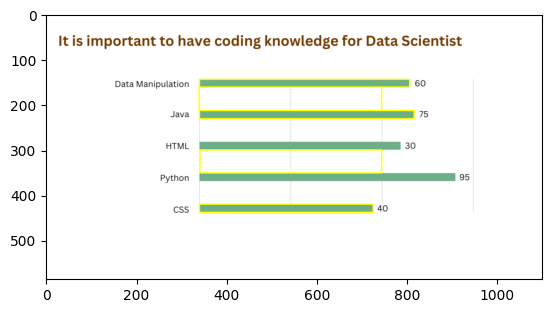

In [13]:
bars = calc_contours(image_path)
contours_right_coords = get_topright_corner(bars[::-1])

In [9]:
from PIL import Image
image = Image.open(image_path)

feature_extractor,tokenizer,model = loadFromLayoutlmv2()

id2label, label2color = labelForBoxes()


output_image, boxes,words,true_predictions,true_boxes,is_subword = process_image(image,id2label,label2color,feature_extractor,tokenizer,model)

words_to_bbox = merge_close_words(words,boxes,image)
bboxes = list(words_to_bbox.values())


/home/danielsyahputra/.cache/pypoetry/virtualenvs/document-parsing-LOpQbM4--py3.10/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


ImportError: 
LayoutLMv2Model requires the detectron2 library but it was not found in your environment. Checkout the instructions on the
installation page: https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [10]:
words_to_boxes = merge_close_words(words,boxes,image)
bboxes = list(words_to_boxes.values())
bboxes.insert(0, [0.0,0.0,0.0,0.0])
bboxes.append( [0.0,0.0,0.0,0.0])
words_d = [list(words_to_boxes.keys())]

updated_categorized_data = graph_categorizer(words_d,bboxes,image)
updated_words_to_bboxes = merge_close_words(words,boxes,image)
contours_right_coords = get_topright_corner(bars[::-1])

contour_to_values = nearest_assignment(updated_categorized_data,updated_words_to_bboxes,contours_right_coords)

sub_output = assign_value_to_keys(updated_categorized_data,updated_words_to_bboxes,contours_right_coords,contour_to_values)

NameError: name 'words' is not defined

In [ ]:
output = {"header": updated_categorized_data['headers'], "Mapping":sub_output}
output
     

Extracted Data:
      x     y
0  99.8  48.4

Metadata:
{'chart_type': 'scatter', 'text_elements': {'title': 'tt ee ae oe ee ee ea bem ea tiann bem', 'x_label': '', 'y_label': ''}, 'axes_info': {'x_scale': {'pixel_range': (50, 550), 'value_range': (0, 100)}, 'y_scale': {'pixel_range': (50, 550), 'value_range': (0, 100)}}}


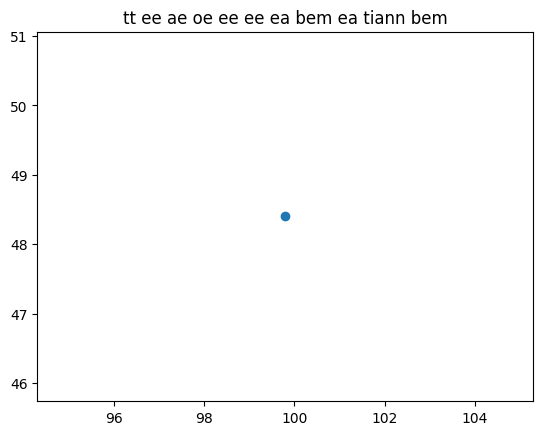

In [15]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

class ChartDataExtractor:
    def __init__(self):
        # Initialize OCR engine
        self.ocr_engine = pytesseract
        
    def preprocess_image(self, image_path):
        """
        Preprocess the chart image for better analysis.
        
        Args:
            image_path (str): Path to the chart image
            
        Returns:
            numpy.ndarray: Preprocessed image
        """
        # Read the image
        image = cv2.imread(image_path)
        
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply thresholding to handle different lighting conditions
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Remove noise using morphological operations
        kernel = np.ones((2,2), np.uint8)
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        return cleaned

    def detect_axes(self, image):
        """
        Detect and extract the axes lines from the chart.
        
        Args:
            image (numpy.ndarray): Preprocessed image
            
        Returns:
            tuple: Coordinates of x and y axes
        """
        # Detect lines using Hough Transform
        edges = cv2.Canny(image, 50, 150, apertureSize=3)
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
        
        horizontal_lines = []
        vertical_lines = []
        
        if lines is not None:
            for rho, theta in lines[:, 0]:
                # Separate horizontal and vertical lines
                if np.abs(theta) < np.pi/4 or np.abs(theta) > 3*np.pi/4:
                    vertical_lines.append((rho, theta))
                else:
                    horizontal_lines.append((rho, theta))
        
        return horizontal_lines, vertical_lines

    def extract_text(self, image, regions):
        """
        Extract text from specified regions using OCR.
        
        Args:
            image (numpy.ndarray): Preprocessed image
            regions (list): List of regions to extract text from
            
        Returns:
            dict: Extracted text by region
        """
        extracted_text = {}
        
        for region_name, (x, y, w, h) in regions.items():
            # Extract region
            roi = image[y:y+h, x:x+w]
            
            # Perform OCR
            text = self.ocr_engine.image_to_string(
                Image.fromarray(roi),
                config='--psm 6'  # Assume uniform block of text
            )
            
            extracted_text[region_name] = text.strip()
            
        return extracted_text

    def extract_data_points(self, image, axes_info):
        """
        Extract data points from the chart based on detected features.
        
        Args:
            image (numpy.ndarray): Preprocessed image
            axes_info (dict): Information about axes location and scale
            
        Returns:
            pandas.DataFrame: Extracted data points
        """
        # Find contours that might represent data points
        contours, _ = cv2.findContours(
            image, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        data_points = []
        
        for contour in contours:
            # Calculate centroid of each potential data point
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                
                # Convert pixel coordinates to data values using axes_info
                x_value = self._pixel_to_value(cx, axes_info['x_scale'])
                y_value = self._pixel_to_value(cy, axes_info['y_scale'])
                
                data_points.append({'x': x_value, 'y': y_value})
        
        return pd.DataFrame(data_points)

    def _pixel_to_value(self, pixel_coord, scale_info):
        """
        Convert pixel coordinates to actual values using scale information.
        
        Args:
            pixel_coord (int): Pixel coordinate
            scale_info (dict): Scale information for conversion
            
        Returns:
            float: Converted value
        """
        # Linear interpolation between known scale points
        pixel_min, pixel_max = scale_info['pixel_range']
        value_min, value_max = scale_info['value_range']
        
        return value_min + (pixel_coord - pixel_min) * (value_max - value_min) / (pixel_max - pixel_min)

    def process_chart(self, image_path):
        """
        Main function to process a chart image and extract data.
        
        Args:
            image_path (str): Path to the chart image
            
        Returns:
            tuple: (pandas.DataFrame, dict) - Extracted data points and metadata
        """
        try:
            # Preprocess the image
            processed_image = self.preprocess_image(image_path)
            
            # Detect axes
            h_lines, v_lines = self.detect_axes(processed_image)
            
            # Define regions for text extraction (adjust based on chart type)
            regions = {
                'title': (50, 10, 500, 50),
                'x_label': (50, 550, 500, 30),
                'y_label': (10, 50, 30, 500)
            }
            
            # Extract text elements
            text_elements = self.extract_text(processed_image, regions)
            
            # Define axes information (would be detected in a full implementation)
            axes_info = {
                'x_scale': {
                    'pixel_range': (50, 550),
                    'value_range': (0, 100)
                },
                'y_scale': {
                    'pixel_range': (50, 550),
                    'value_range': (0, 100)
                }
            }
            
            # Extract data points
            data = self.extract_data_points(processed_image, axes_info)
            
            # Add metadata
            metadata = {
                'chart_type': 'scatter',  # Would be detected in full implementation
                'text_elements': text_elements,
                'axes_info': axes_info
            }
            
            return data, metadata
            
        except Exception as e:
            print(f"Error processing chart: {str(e)}")
            return None, None

# Example usage
if __name__ == "__main__":
    extractor = ChartDataExtractor()
    
    # Process a chart
    data, metadata = extractor.process_chart('chart1.png')
    
    if data is not None:
        print("Extracted Data:")
        print(data.head())
        print("\nMetadata:")
        print(metadata)
        
        # Visualize extracted points
        plt.scatter(data['x'], data['y'])
        plt.title(metadata['text_elements'].get('title', 'Extracted Data Points'))
        plt.xlabel(metadata['text_elements'].get('x_label', 'X'))
        plt.ylabel(metadata['text_elements'].get('y_label', 'Y'))
        plt.show()

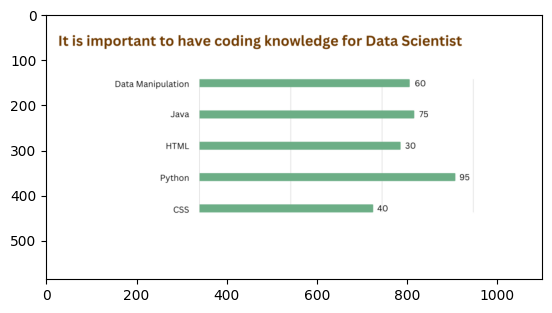

In [16]:
plt.imshow(img)

In [22]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

class OpenCVChartExtractor:
    def __init__(self):
        """
        Initialize the chart extraction system using classical OpenCV approaches.
        """
        self.ocr_engine = pytesseract

    def preprocess_image(self, image):
        """
        Preprocess the input image for better feature detection.
        
        Args:
            image (numpy.ndarray): Input image
            
        Returns:
            numpy.ndarray: Preprocessed image
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            blurred, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 11, 2
        )
        
        # Remove small noise using morphological operations
        kernel = np.ones((3, 3), np.uint8)
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        return cleaned

    def detect_chart_regions(self, image):
        """
        Detect potential chart regions using contour detection and geometric analysis.
        
        Args:
            image (numpy.ndarray): Preprocessed image
            
        Returns:
            list: List of detected chart regions (x, y, w, h)
        """
        # Find contours
        contours, _ = cv2.findContours(
            image, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        chart_regions = []
        
        for contour in contours:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            
            # Calculate aspect ratio and area
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            
            # Filter based on typical chart characteristics
            if (0.5 <= aspect_ratio <= 2.0 and  # Reasonable aspect ratio
                area > 1000 and                  # Minimum area
                cv2.isContourConvex(contour)):   # Should be convex
                
                chart_regions.append((x, y, w, h))
        
        return chart_regions

    def identify_chart_type(self, region_image):
        """
        Identify the type of chart using geometric features and pattern analysis.
        
        Args:
            region_image (numpy.ndarray): Cropped chart image
            
        Returns:
            str: Chart type ('bar' or 'line')
        """
        # Detect edges
        edges = cv2.Canny(region_image, 50, 150)
        
        # Find lines using Hough transform
        lines = cv2.HoughLinesP(
            edges, 1, np.pi/180, 50, 
            minLineLength=30, maxLineGap=10
        )
        
        if lines is None:
            return 'unknown'
        
        # Count vertical and horizontal lines
        vertical_lines = 0
        horizontal_lines = 0
        
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
            
            if angle < 30 or angle > 150:  # Near vertical
                vertical_lines += 1
            elif 60 < angle < 120:         # Near horizontal
                horizontal_lines += 1
        
        # Analyze line patterns
        if vertical_lines > horizontal_lines * 1.5:
            return 'bar'
        else:
            # Check for continuous curves
            contours, _ = cv2.findContours(
                edges, 
                cv2.RETR_EXTERNAL, 
                cv2.CHAIN_APPROX_SIMPLE
            )
            
            if contours:
                longest_contour = max(contours, key=cv2.arcLength)
                if cv2.arcLength(longest_contour, False) > region_image.shape[1] * 0.5:
                    return 'line'
        
        return 'unknown'

    def extract_axes(self, image):
        """
        Extract and analyze chart axes.
        
        Args:
            image (numpy.ndarray): Chart image
            
        Returns:
            tuple: (x_axis, y_axis) information
        """
        # Detect edges
        edges = cv2.Canny(image, 50, 150)
        
        # Find lines using Hough transform
        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)
        
        x_axis = None
        y_axis = None
        
        if lines is not None:
            for rho, theta in lines[:, 0]:
                # Convert polar coordinates to Cartesian
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                
                # Calculate endpoints
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                
                # Classify as x or y axis based on angle
                if abs(theta) < np.pi/4:  # Near vertical
                    if y_axis is None or abs(rho) < abs(y_axis[0]):
                        y_axis = (rho, theta, (x1, y1), (x2, y2))
                elif abs(theta - np.pi/2) < np.pi/4:  # Near horizontal
                    if x_axis is None or abs(rho) > abs(x_axis[0]):
                        x_axis = (rho, theta, (x1, y1), (x2, y2))
        
        return x_axis, y_axis

    def extract_bar_chart_data(self, image, x_axis, y_axis):
        """
        Extract data from bar charts using contour detection and measurement.
        
        Args:
            image (numpy.ndarray): Chart image
            x_axis (tuple): X-axis information
            y_axis (tuple): Y-axis information
            
        Returns:
            pandas.DataFrame: Extracted data
        """
        # Create mask for bar detection
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        h, w = image.shape[:2]
        
        if x_axis and y_axis:
            # Define chart area using axes
            _, _, (x1, y1), (x2, y2) = y_axis
            chart_region = image[0:int(y2), int(x1):w]
        else:
            # Fallback to full image
            chart_region = image
        
        # Threshold to detect bars
        _, thresh = cv2.threshold(
            chart_region, 0, 255, 
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
        
        # Find contours (bars)
        contours, _ = cv2.findContours(
            thresh, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        # Extract bar data
        bars_data = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if h > 10 and w > 5:  # Filter out noise
                bars_data.append({
                    'position': x + w/2,
                    'height': h,
                    'width': w
                })
        
        # Sort bars by position
        bars_data = sorted(bars_data, key=lambda x: x['position'])
        
        # Extract axis labels and scale
        y_scale = self._extract_y_scale(image)
        x_labels = self._extract_x_labels(image)
        
        # Create DataFrame
        data = []
        for i, bar in enumerate(bars_data):
            category = x_labels[i] if i < len(x_labels) else f'Category {i+1}'
            value = self._pixel_to_value(bar['height'], y_scale)
            data.append({
                'Category': category,
                'Value': value
            })
        
        return pd.DataFrame(data)

    def extract_line_chart_data(self, image, x_axis, y_axis):
        """
        Extract data from line charts using edge detection and curve tracing.
        
        Args:
            image (numpy.ndarray): Chart image
            x_axis (tuple): X-axis information
            y_axis (tuple): Y-axis information
            
        Returns:
            pandas.DataFrame: Extracted data points
        """
        # Detect edges
        edges = cv2.Canny(image, 50, 150)
        
        # Find lines representing the curve
        lines = cv2.HoughLinesP(
            edges, 1, np.pi/180, 50, 
            minLineLength=30, maxLineGap=10
        )
        
        # Extract points from lines
        points = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                points.extend([(x1, y1), (x2, y2)])
        
        # Sort points by x-coordinate
        points = sorted(points, key=lambda x: x[0])
        
        # Remove duplicate and nearby points
        filtered_points = []
        for point in points:
            if not filtered_points or \
               abs(point[0] - filtered_points[-1][0]) > 10:
                filtered_points.append(point)
        
        # Extract scales
        x_scale = self._extract_x_scale(image)
        y_scale = self._extract_y_scale(image)
        
        # Convert to values
        data = []
        for x, y in filtered_points:
            x_value = self._pixel_to_value(x, x_scale)
            y_value = self._pixel_to_value(y, y_scale)
            data.append({
                'X': x_value,
                'Y': y_value
            })
        
        return pd.DataFrame(data)

    def _extract_y_scale(self, image):
        """
        Extract y-axis scale using OCR and pattern analysis.
        
        Args:
            image (numpy.ndarray): Chart image
            
        Returns:
            dict: Scale information
        """
        height = image.shape[0]
        # Extract y-axis region (left 10% of image)
        y_region = image[:, :int(image.shape[1] * 0.1)]
        
        # Perform OCR
        text = self.ocr_engine.image_to_string(
            Image.fromarray(y_region),
            config='--psm 6 -c tessedit_char_whitelist=0123456789.'
        )
        
        # Extract numeric values
        values = []
        for line in text.split('\n'):
            try:
                value = float(line.strip())
                values.append(value)
            except ValueError:
                continue
        
        if len(values) >= 2:
            return {
                'pixel_range': (height * 0.9, height * 0.1),
                'value_range': (min(values), max(values))
            }
        
        # Fallback to default scale
        return {
            'pixel_range': (height * 0.9, height * 0.1),
            'value_range': (0, 100)
        }

    def _extract_x_labels(self, image):
        """
        Extract x-axis labels using OCR.
        
        Args:
            image (numpy.ndarray): Chart image
            
        Returns:
            list: Extracted labels
        """
        # Extract bottom region of image
        height = image.shape[0]
        x_region = image[int(height * 0.9):, :]
        
        # Perform OCR
        text = self.ocr_engine.image_to_string(
            Image.fromarray(x_region)
        )
        
        # Clean and split labels
        labels = text.split('\n')
        return [label.strip() for label in labels if label.strip()]

    def _pixel_to_value(self, pixel_coord, scale_info):
        """
        Convert pixel coordinates to actual values.
        
        Args:
            pixel_coord (float): Pixel coordinate
            scale_info (dict): Scale information
            
        Returns:
            float: Converted value
        """
        pixel_min, pixel_max = scale_info['pixel_range']
        value_min, value_max = scale_info['value_range']
        
        return value_min + (pixel_coord - pixel_min) * \
               (value_max - value_min) / (pixel_max - pixel_min)

    def process_image(self, image_path):
        """
        Process an image to extract charts and their data.
        
        Args:
            image_path (str): Path to the input image
            
        Returns:
            dict: Extracted chart data
        """
        # Read image
        image = cv2.imread(image_path)
        
        # Preprocess image
        preprocessed = self.preprocess_image(image)
        
        # Detect chart regions
        regions = self.detect_chart_regions(preprocessed)
        
        results = {}
        for i, (x, y, w, h) in enumerate(regions):
            # Extract region
            region_image = image[y:y+h, x:x+w]
            
            # Identify chart type
            chart_type = self.identify_chart_type(region_image)
            
            if chart_type == 'unknown':
                continue
                
            # Extract axes
            x_axis, y_axis = self.extract_axes(region_image)
            
            # Extract data based on chart type
            if chart_type == 'bar':
                data = self.extract_bar_chart_data(region_image, x_axis, y_axis)
            else:  # line chart
                data = self.extract_line_chart_data(region_image, x_axis, y_axis)
            
            # Store results
            results[f'chart_{i+1}'] = {
                'type': chart_type,
                'data': data,
                'region': (x, y, w, h)
            }
        
        return results

# Example usage
if __name__ == "__main__":
    # Initialize extractorextractor = OpenCVChartExtractor()
    
    # Process an image
    results = extractor.process_image('chart1.png')
    
    # Display results
    for chart_name, chart_data in results.items():
        print(f"\nProcessing {chart_name}:")
        print(f"Chart type: {chart_data['type']}")
        print("\nExtracted data:")
        print(chart_data['data'].head())
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        
        if chart_data['type'] == 'bar':
            plt.bar(chart_data['data']['Category'], 
                   chart_data['data']['Value'])
            plt.xticks(rotation=45)
            plt.xlabel('Categories')
            plt.ylabel('Values')
        else:  # line chart
            plt.plot(chart_data['data']['X'], 
                    chart_data['data']['Y'])
            plt.xlabel('X Values')
            plt.ylabel('Y Values')
        
        plt.title(f'{chart_name} - {chart_data["type"].capitalize()} Chart')
        plt.tight_layout()
        
        # Save visualization
        plt.savefig(f'{chart_name}_visualization.png')
        plt.close()
        
        # Export data to CSV
        # chart_data['data'].to_csv(f'{chart_name}_data.csv', index=False)

In [23]:
data

,x,y
0,99.8,48.4
